# Entrainer les agents addi

## Settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reset -f
%load_ext autoreload
%autoreload 2

In [1]:
%cd /content/drive/MyDrive/permanent/RECHERCHE2/ml_flux_euler/

/content/drive/MyDrive/permanent/RECHERCHE2/ml_flux_euler


In [2]:
import Euler.core_solver as core
import Euler.agent_addi as aga
import Euler.neural_networks as nn

from Euler.backend import K
from Euler.param import Param,Projecter
from Euler.initial_conditions import GenParam,FuncGenerator

#from Euler.backend import K
import matplotlib.pyplot as plt
import popup_lib.popup as pop
import numpy as np
import copy

Popup loaded!


### Paramètres globaux

ça serait bien d'essayer l'entrainement avec des conditions de neumann. Le générateur de fonction est beaucoup plus générique (mais plus lent). 

Attention à la génération: 
* si les fonctions sont trop grandes: cela pête
* si les fonctions sont trop petites: cela n'apprend pas 

In [3]:
param = Param(nx=1000,batch_size=64,nx_ratio=10,
              BC_solver=Param.BC_periodic,
              BC_model=Param.BC_periodic)
k_tf32=K("tf",32)

Param initialised with, nx=1000, nx_coarse=99, batch_size=64


Paramètres de génération des données.

Pour avoir uniquement des créneaux, mettre `discontinuousPart_scale=0`. 

On peut aussi ajouter `discountinousPart_ratio=alpha`. Dans ce cas la hauteur des discontinuités sera un ratio (aléatoire entre `alpha` et `-alpha`) de la hauter de chaque fonction. 


In [4]:
genParam=GenParam(param,kind=GenParam.kind_loop)
genParam.continuousPart_scale = 0.5
genParam.discontinuousPart_scale =0.5
genParam.sod_scale=0.5
genParam.initial_speed_factor= 1
generator=FuncGenerator(genParam, param, k_tf32)

## Observons les conditions initiales

### continuités et discontinuités

Attention, les dessins ci-dessous sont les parties continues et discontinues avant leur scaling. 

In [5]:
def test_components():
    discount_loop=generator.generate_loop_dicontinuity()
    discount_changing=generator.generate_changing_discontinuity()
    countinuity=generator.generate_fourier()

    fig,axs=plt.subplots(5,3,sharey="all")
    for i in range(5):
        axs[i,0].plot(discount_loop[i,:])
        axs[i,1].plot(discount_changing[i, :])
        axs[i, 2].plot(countinuity[i, :])

    axs[0,0].set_title("loop")
    axs[0,1].set_title("changing")
    axs[0,2].set_title("continuity")

    plt.show()

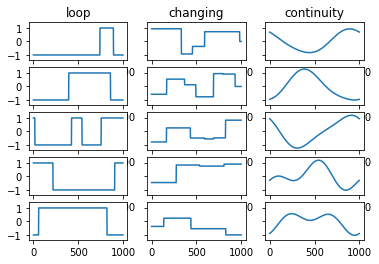

In [6]:
test_components()

### Les 3 quantités

Une donnée `W`, c'est un batch de triplet $\rho,\rho V,E$

In [9]:
W = generator.init_W()
W.shape

TensorShape([64, 1000, 3])

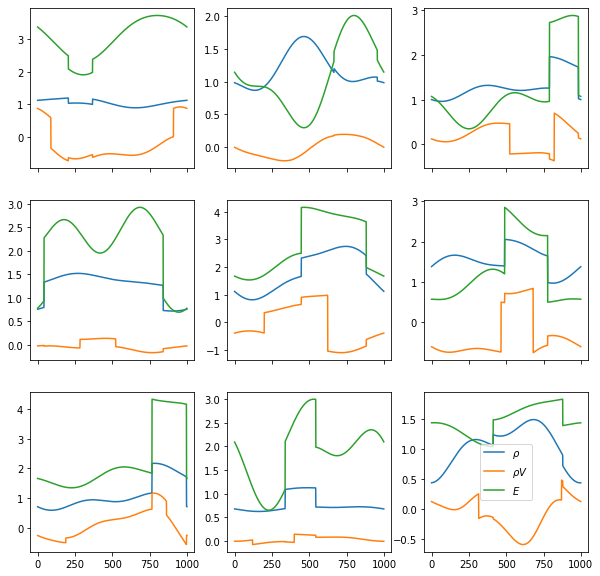

In [10]:
fig,axs=plt.subplots(3,3,sharex="all",figsize=(10,10))
axs=axs.flatten()

for i in range(9):
    axs[i].plot(W[i,:,0],label=r"$\rho$")
    axs[i].plot(W[i,:,1],label=r"$\rho V$")
    axs[i].plot(W[i,:,2],label="$E$")
plt.legend()
plt.show()

## Observons le solver

### Projection

In [11]:
projecter=Projecter(param.nx_ratio,32)

In [12]:
W_proj=projecter.projection(W)
W_proj.shape

TensorShape([64, 99, 3])

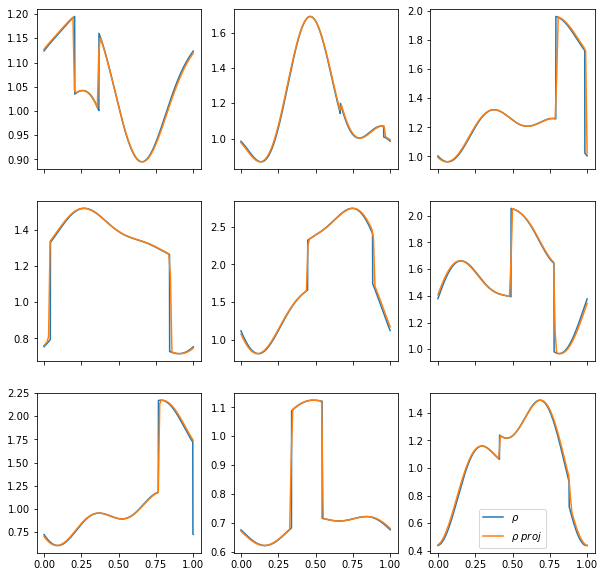

In [13]:
fig,axs=plt.subplots(3,3,sharex="all",figsize=(10,10))
axs=axs.flatten()

x=np.linspace(param.xmin,param.xmax,param.nx)
x_proj=np.linspace(param.xmin,param.xmax,param.nx_coarse)
for i in range(9):
    axs[i].plot(x,W[i,:,0],label=r"$\rho$")
    axs[i].plot(x_proj,W_proj[i,:,0],label=r"$\rho\ proj$")
    
plt.legend()
plt.show()

### Dynamique

In [14]:
nb_t = 500
W_coarse=W_proj
res,_=core.compute_solutions(param, nb_t, W, False,k_tf32)
res_coarse,_=core.compute_solutions(param, nb_t, W_coarse, True,k_tf32)

In [15]:
def see_evolution(batch_i):

    fig, ax = plt.subplots(3, 2,figsize=(10,10))

    for t in range(0, nb_t, nb_t // 10):
        color = "r" if t == 0 else "k"
        alpha = 1 if t == 0 else t / nb_t
        ax[0,0].set_title("rho")
        ax[0,0].plot(res[t, batch_i, :, 0], color, alpha=alpha)
        ax[0,1].plot(res_coarse[t, batch_i, :, 0], color, alpha=alpha)
        ax[1,0].set_title("rhoV")
        ax[1,0].plot(res[t, batch_i, :, 1], color, alpha=alpha)
        ax[1,1].plot(res_coarse[t, batch_i, :, 1], color, alpha=alpha)
        ax[2,0].set_title("E")
        ax[2,0].plot(res[t, batch_i, :, 2], color, alpha=alpha)
        ax[2,1].plot(res_coarse[t, batch_i, :, 2], color, alpha=alpha)

    fig.tight_layout()

    plt.show()

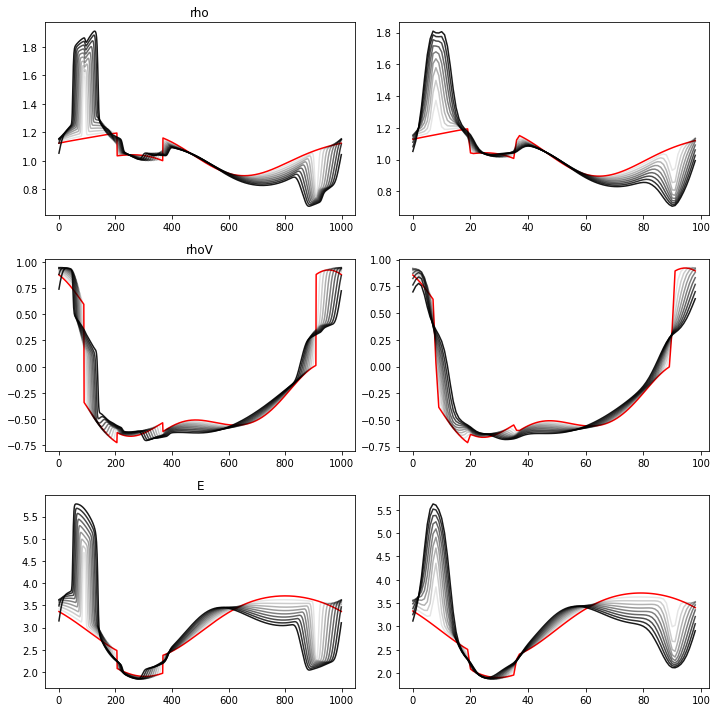

In [16]:
see_evolution(0)

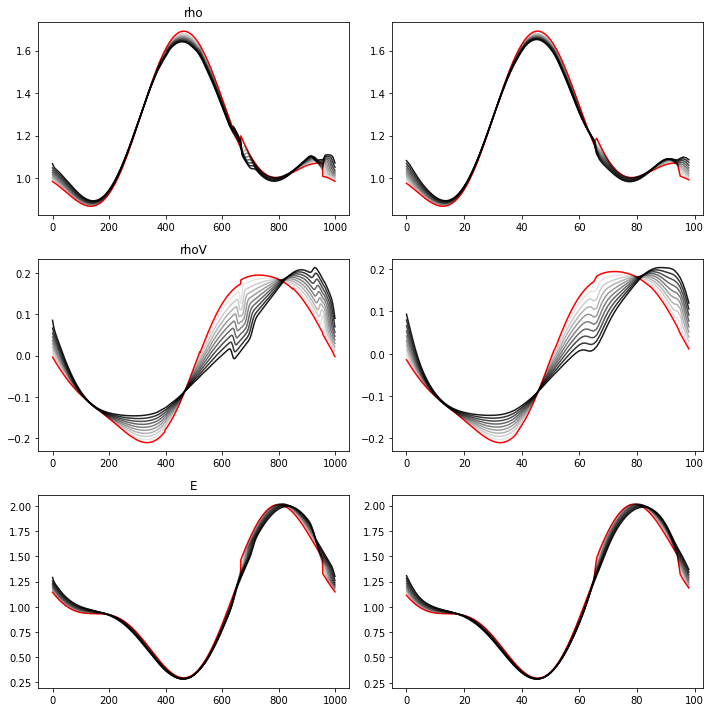

In [17]:
see_evolution(1)

### Comparons fine et HLL

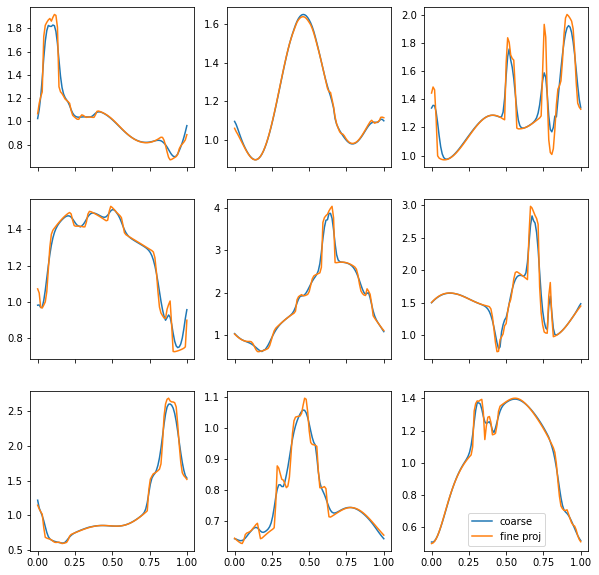

In [18]:
fig,axs=plt.subplots(3,3,sharex="all",figsize=(10,10))
axs=axs.flatten()

for i,ax in enumerate(axs):
    ax.plot(x_proj,res_coarse[-1, i, :, 0],label="coarse")
    res_proj=projecter.projection(res[-1])
    ax.plot(x_proj,res_proj[i, :, 0],label="fine proj")
ax.legend();

## Un agent au travail

Voici les `famparams` qui paramétrise un agent: 

In [25]:
def make_agent():
    nb_t=20
    agent = aga.Agent_addi(param, nn.Difference_model_tricky(param,5),
                            lossCoef_stab=1.,
                            lossCoef_disHLL=1e-2,
                            lossCoef_ridge=0,
                           )
    W_train, Y_train = core.generate_fine_solutions(genParam,param, nb_t,k_tf32)
    agent.load_WY_train(W_train, Y_train)
    W_val, Y_val = core.generate_fine_solutions(genParam,param, nb_t,k_tf32)
    agent.load_WY_valid(W_val, Y_val)

    return agent


agent=make_agent()
losses_stab=[]
losses_dist_HLL=[]
losses_ridge=[]

traçage de la méthode _load_WY_accelerated


In [26]:
loss_stab = agent.optimize()
print(loss_stab)

Traçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
(7.086691e-05, 0.0, 0.0)


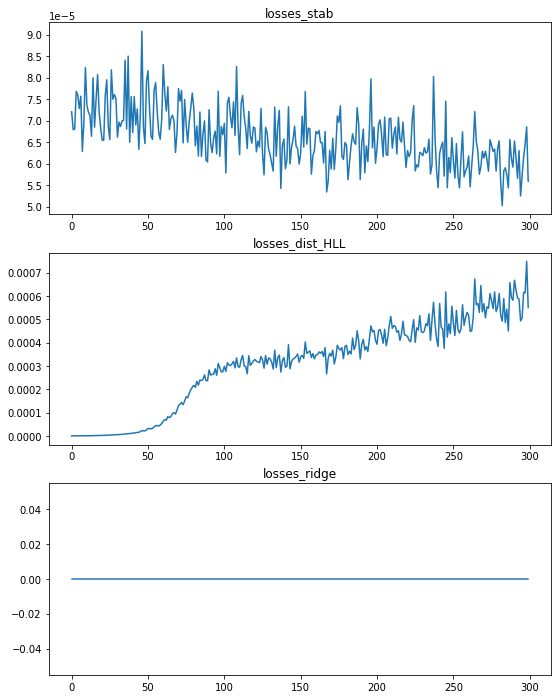

In [29]:
for _ in range(100):
    loss_stab,loss_dist_HLL,loss_ridge = agent.optimize()
    losses_stab.append(loss_stab)
    losses_dist_HLL.append(loss_dist_HLL)
    losses_ridge.append(loss_ridge)


    if  np.isnan(loss_stab):
        print("la loss_stab est nan:")
    if  np.isnan(loss_dist_HLL):
        print("la loss_dist_HLL est nan:")
    if  np.isnan(loss_ridge):
        print("la loss_ridge est nan:")


fig,axs=plt.subplots(3,1,figsize=(9,12))
axs[0].plot(losses_stab)
axs[0].set_title("losses_stab")
axs[1].plot(losses_dist_HLL)
axs[1].set_title("losses_dist_HLL")
axs[2].plot(losses_ridge)
axs[2].set_title("losses_ridge")

plt.show()

Les 3 loss sont calculée sur des batch de train. 

* `loss_disHLL`: la distance entre la différence de flux HLL, et celle donnée par le model moyennée lors d'une évolution temporelle de `watch_duration`
* `loss_stab`: la distance entre la solution de référence et celle produite par le modèle à la fin d'une évolution durant `watch_duration`
* `loss_ridge`: la pénalisation : la somme des carré des poids pondérée par le `lossCoef_ridge`


Les deux indicateurs suivant sont sur le jeu de validation. 

* `HLL_error`: la distance entre la solution de référence et celle produite par HLL après une évolutions temporelle longue (typiquement `nb_t=500`). Elle est constante tant que l'on ne charge pas un nouveau jeu de validation. 
* `score_stab`: c'est le ration `HLL_error` sur `model_error`. Quand il est plus grand que 1 on est content

Ci-dessus: on s'éloigne un peu de HLL, et le score s'amétiore. 

Ci-dessous: On décide de se rapprocher uniquement de HLL. Mais du coup le score descend. 

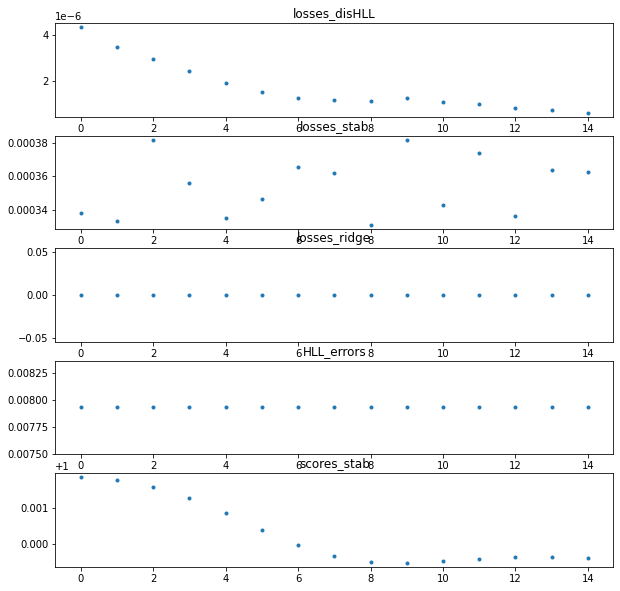

In [ ]:
famparams={
            "lossCoef_stab":0,
            "lossCoef_ridge":0,
            "lossCoef_disHLL":1,
            "watch_duration":10
        }
look_at_loss(agent,famparams)

ci-dessous: on remet les paramètre qui permette de remonter au score. 

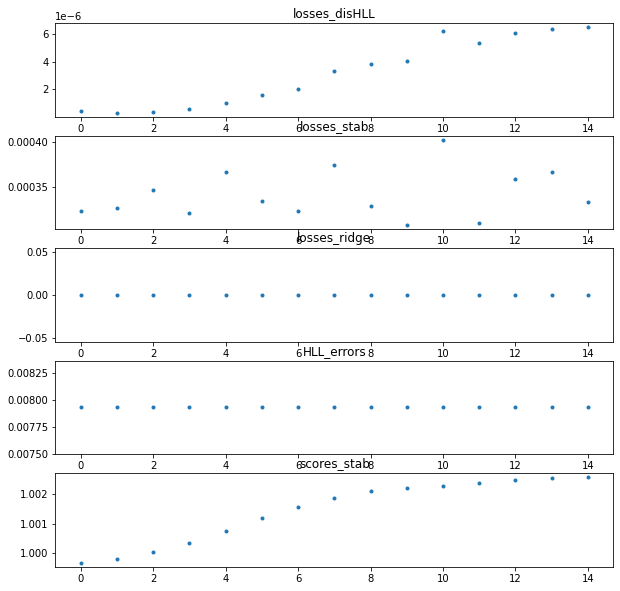

In [ ]:
famparams={
            "lossCoef_stab":1,
            "lossCoef_ridge":0,
            "lossCoef_disHLL":1,
            "watch_duration":10
        }
look_at_loss(agent,famparams)

ci-dessous: on fait juste de la pénalisation: le score redescent naturellement. 

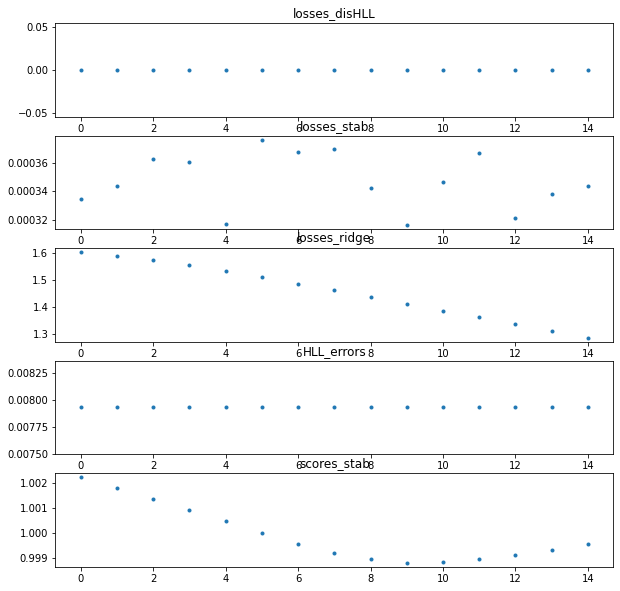

In [ ]:
famparams={
            "lossCoef_stab":0,
            "lossCoef_ridge":1,
            "lossCoef_disHLL":0,
            "watch_duration":10
        }
look_at_loss(agent,famparams)

Attention, la `loss ridge` est très grande par rapport au 2 autres. Il faut mettre un petit coef devant. 

## Des familles d'agents

Un `Family_trainer` de `popup` entraine plusieurs agent. 
* Les plus mauvais reçoivent les poids records des meilleurs (éventuellement moyenné sur plusieurs records).  
* Les plus mauvais reçoivent aussi les `famparams` des meilleurs, mais en les perturbant aléatoirement. Voici des exemples une méthode de perturbation (méthode attachée aux agents).


    def set_and_perturb_famparams(self, famparam, period_count: int):
        self.famparams = famparam
        self.famparams["lossCoef_stab"]*=np.random.choice([0.7,1.5])
        self.famparams["lossCoef_ridge"] *= np.random.choice([0.7, 1.5])
        self.famparams["lossCoef_disHLL"] *= np.random.choice([0.7, 1.5])


Quand un agent est à la fois le meilleurs (avec ses poids records), mais aussi le pire (avec ses poids courants), on dit qu'il est décadent (c'est une forme de sur-apprentissage). Dans ce cas là, le family_trainer lance la méthode `perturb_famparams_on_decadence` dont voici un exemple:

    def perturb_famparams_on_decadence(self,period_count):
        # c'est le seul coef qui fait quelque chose contre le sur-apprentissage
        self.famparams["lossCoef_ridge"] *= 2
        # on imagine qu'on est tombé dans un minimum local. On augmente les learning rate pour en sortir
        self.famparams["lossCoef_disHLL"] *= 2
        self.famparams["lossCoef_stab"] *= 2


In [ ]:
fam_size=5
period_duration="20 seconds"
all_agents=[]

### Agents et familyTrainers

In [ ]:
def family_full(window_size,color):
        name="full_"+str(window_size)
        agents=[]
        for _ in range(fam_size):
            agent= aga.Agent_addi(param, nn.Difference_model_tricky(param,window_size),
                            lossCoef_stab=1.,
                            nb_optimization=20,
                            watch_duration=5
                            )
            agents.append(agent)
            all_agents.append(agent)
            
        return pop.Family_trainer(
            agents=agents,
            nb_bestweights_averaged=3,
            nb_strong=3,
            period_duration=period_duration,
            name=name,
            color=color)

family_trainers=[
                 family_full(5,"red"),
                 #family_full(3,"blue"),
                 ]

toto
toto
toto
toto
toto


### chargement des datas

* On peut entrainer avec le jeu `loop` (périodique)
* On peut entrainer avec le jeu `changing` (non-périodique, sauts plus variés)
* On peut entrainer avec des BC égale à `neumann` ou `periodic`. Notons qu'avec le jeu `changing`, le BC périodic introduit une discontinuité systèmatique sur les bords, mais ce n'est pas trop grave. 
* pour une raison que je ne comprend pas, `reflexive` marche très très mal. 


* On peut aussi modifier le `genParam` en cours d'entrainement. Par alternance (en utilisant un conteur global). Ou bien en intérompant la boucle d'entrainement et en modifiant l'objet `genParam` à la main. 

In [ ]:
# un conteur global
#global_count={"count":-1}

In [ ]:
def load_data():
    # global_count["count"]+=1
    # if global_count["count"]%2==0:
    #     param.BC="periodic"
    # else:
    #     param.BC="neumann"
    nb_t=100#500

    W_train, Y_train = core.generate_fine_solutions(genParam,param, nb_t,k_tf32)
    W_val, Y_val = core.generate_fine_solutions(genParam,param, nb_t,k_tf32)
    for agent in all_agents:
        agent.load_WY_train(W_train, Y_train)
        agent.load_WY_valid(W_val, Y_val)

### ***@Entrainement@***

On peut interrompre la boucle d'apprentissage (une fois l'échauffement fini). Cela permet d'observer l'history notamment.

Mais attention:  pour reprendre un entrainement intérompu:  si entre temps vous avez modifier le paramètre global "param", il faut le rétablir dans une version compatible avec l'agent qui a commencé à s'entrainer (même `batch_size`, même `nx`, même `nx_coarse`,...). 


In [ ]:
try:
    for i in range(100):
        load_data()
        for family_trainer in family_trainers:
            family_trainer.period()
except KeyboardInterrupt:
    for family_trainer in family_trainers:
        #pour pouvoir reprendre si on veut
        family_trainer.interupt_period()


full_5,échauffement Traçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
a↗1.0422Traçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
b↗1.0989Traçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
c↗1.0611Traçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
d↗1.0195Traçage de la méthode gradient_tape
Traçage de la méthode gradient_tape
e↗1.0618
full_5,period:1 a↗1.1261b↗1.2774c↗1.1533d↗1.0663e↗1.1719a↗1.2861b↗1.535c↗1.3343d↗1.1879, mutations:e⇇c|
full_5,period:2 -------, mutations:a↫a|
full_5,period:3 b↗1.6311c↗1.4592d↗1.6578e↗1.4892a↗1.4337b↗1.7209c↗1.482d↗1.7981, mutations:a↫a⇇b|
full_5,period:4 -----e↗1.5084-, mutations:c⇇d|
full_5,period:5 -c↗1.5914--a↗1.6071b↗1.8233-, mutations:c⇇d⇇b|
full_5,period:6 --------, mutations:a↫a⇇b↫a|
full_5,period:7 -------, mutations:a↫a⇇b↫a↫a|
full_5,period:8 --------, mutations:a↫a⇇b↫a↫a↫a|
full_5,period:9 --

### Historique des `famparams`

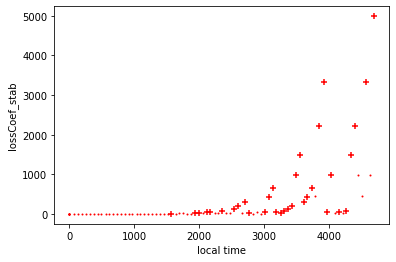

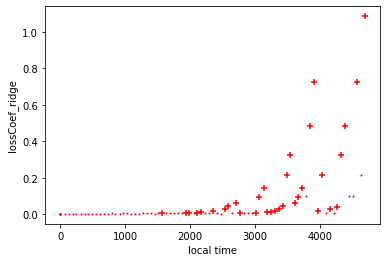

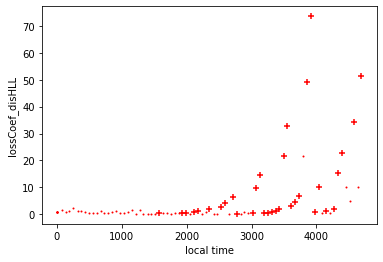

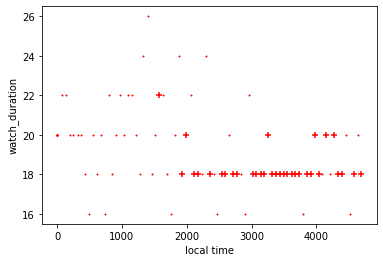

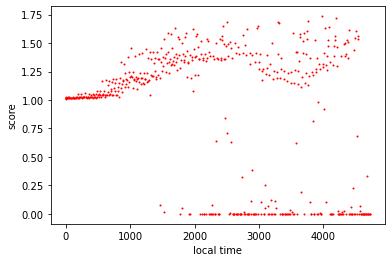

In [ ]:
def plot_history_famparams():
    keys=["lossCoef_stab","lossCoef_ridge","lossCoef_disHLL","watch_duration","score"]

    for k in keys:
        fig,ax=plt.subplots()
        for family_trainer in family_trainers:
            family_trainer.plot_metric(k,ax)

    plt.show()
plot_history_famparams()

### Historique des trois `loss`

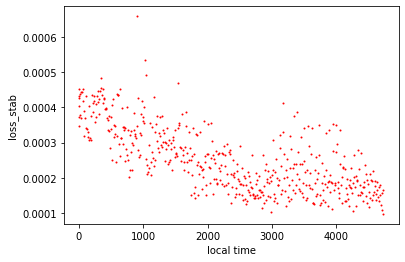

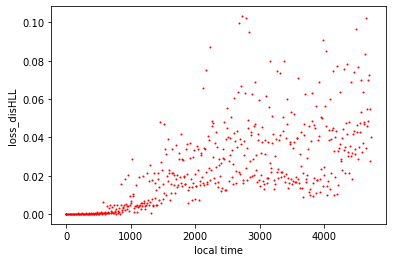

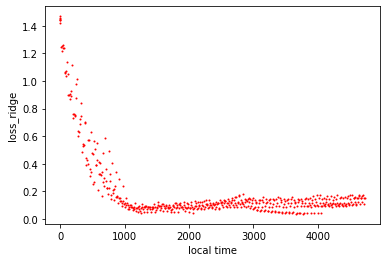

In [ ]:
def plot_history_losses():
    keys=["loss_stab","loss_disHLL","loss_ridge"]

    for k in keys:
        fig,ax=plt.subplots()
        for family_trainer in family_trainers:
            family_trainer.plot_metric(k,ax)

    plt.show()
plot_history_losses()

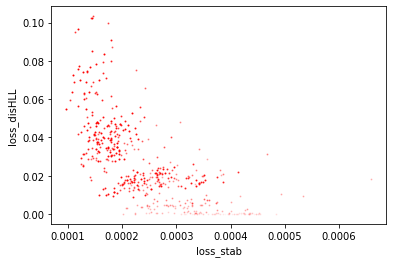

In [ ]:
fig,ax=plt.subplots()
for family_trainer in family_trainers:
    family_trainer.plot_two_metrics("loss_stab","loss_disHLL",ax)

## Testons sur le jeu "loop" (périodique)

In [ ]:
import tensorflow as tf
family_trainer=family_trainers[0]
best_agent=family_trainer.get_best_agent()
nb_t=500

#attention, modification des paramètres globaux
genParam.kind=GenParam.kind_loop
param.BC_solver=param.BC_model=Param.BC_periodic

In [ ]:
W_val, Y_val = core.compute_fine_solutions_3(genParam,param, nb_t)
best_agent.load_WY_valid(W_val, Y_val)

durée du calcul de la solution fine: 1.691863775253296

In [ ]:
def check_Nan_compute_errors():
    w_coarse, w_final_projected=best_agent.give_results(True)
    w_coarse_HLL, _=best_agent.give_results(False)

    nans0=tf.math.is_nan(tf.reduce_sum(w_coarse,axis=[1,2]))
    print("\nnombre de Nan produit par le modèle:",tf.reduce_sum(tf.cast(nans0,tf.int32)).numpy())
    nans1=tf.math.is_nan(tf.reduce_sum(w_coarse_HLL,axis=[1,2]))
    print("nombre de Nan produit par HLL:",tf.reduce_sum(tf.cast(nans1,tf.int32)).numpy())
    nans2=tf.math.is_nan(tf.reduce_sum(w_final_projected,axis=[1,2]))
    print("nombre de Nan dans la solution de référence:",tf.reduce_sum(tf.cast(nans2,tf.int32)).numpy())

    seuil=2
    big0=tf.reduce_mean(np.abs(w_coarse),axis=[1,2])>seuil
    print("nombre de big error produit par le modèle:",tf.reduce_sum(tf.cast(big0,tf.int32)).numpy())
    big1=tf.reduce_mean(np.abs(w_coarse_HLL),axis=[1,2])>seuil
    print("nombre de big error produit par HLL:",tf.reduce_sum(tf.cast(big1,tf.int32)).numpy())
    big2=tf.reduce_mean(np.abs(w_final_projected),axis=[1,2])>seuil
    print("nombre de big error produit par la solution de référence:",tf.reduce_sum(tf.cast(big2,tf.int32)).numpy())
    

    nans=nans0|nans1|nans2|big0|big1|big2

    errors_model=np.abs(w_coarse - w_final_projected)[~nans]
    errors_HLL=np.abs(w_coarse_HLL - w_final_projected)[~nans]

    error_model=np.mean(errors_model)
    error_HLL = np.mean(errors_HLL)
    score=error_HLL/error_model

    print("error_model",error_model)
    print("error_HLL",error_HLL)
    print("score",score)

    return w_coarse, w_final_projected,w_coarse_HLL,errors_model,errors_HLL


In [ ]:
w_coarse, w_final_projected,w_coarse_HLL,errors_model,errors_HLL=check_Nan_compute_errors()


nombre de Nan produit par le modèle: 0
nombre de Nan produit par HLL: 0
nombre de Nan dans la solution de référence: 0
nombre de big error produit par le modèle: 1
nombre de big error produit par HLL: 0
nombre de big error produit par la solution de référence: 0
error_model 0.030595168
error_HLL 0.053274535
score 1.7412728


Ce que produise nos modèles

In [ ]:
def for_one_channel(channel,w_coarse,w_coarse_HLL, w_final_projected):
    fig,axs=plt.subplots(6,2,figsize=(9,20))
    fig.suptitle(family_trainer.name)
    axs=axs.flatten()
    xs=np.linspace(param.xmin,param.xmax,param.nx_coarse)
    ax=None
    for i,ax in enumerate(axs):
        ax.plot(xs,w_final_projected[i,:,channel],label="fine",color="black")
        ax.plot(xs,w_coarse_HLL[i,:,channel],label="HLL",color="blue")
        ax.plot(xs,w_coarse[i,:,channel],label="model",color="red")
    ax.legend()

### Densités

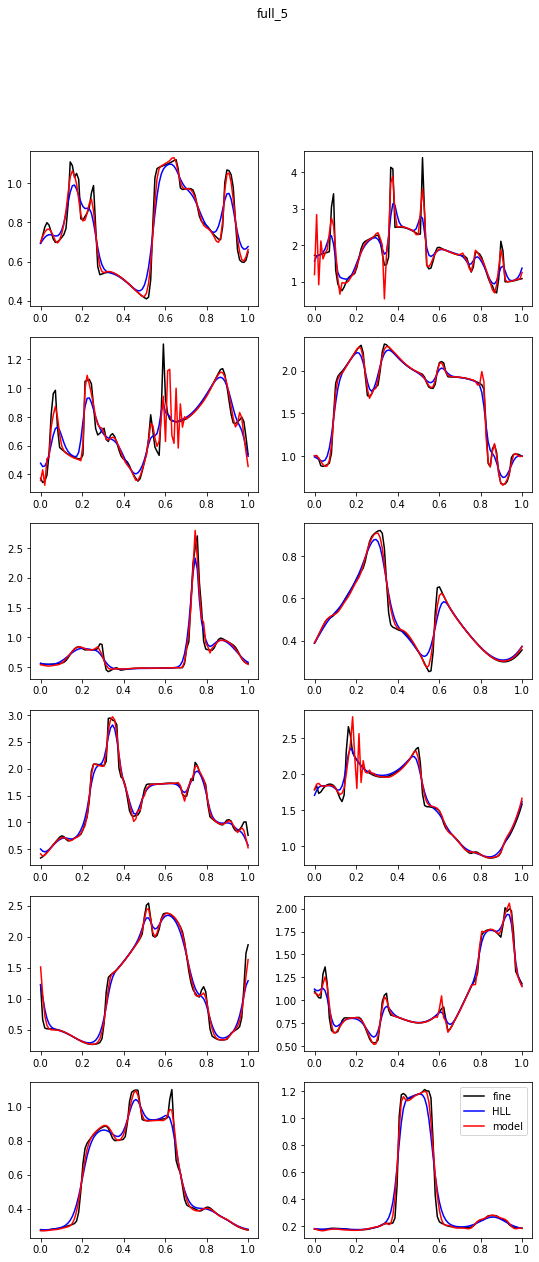

In [ ]:
for_one_channel(0,w_coarse,w_coarse_HLL, w_final_projected)

### rho V

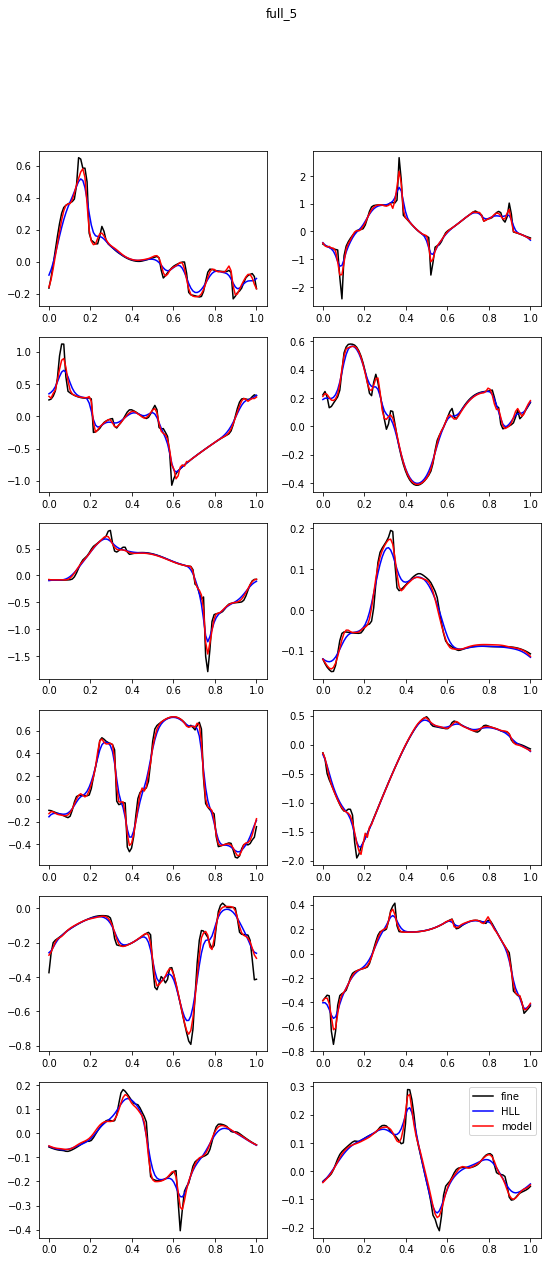

In [ ]:
for_one_channel(1,w_coarse,w_coarse_HLL, w_final_projected)

### Energie

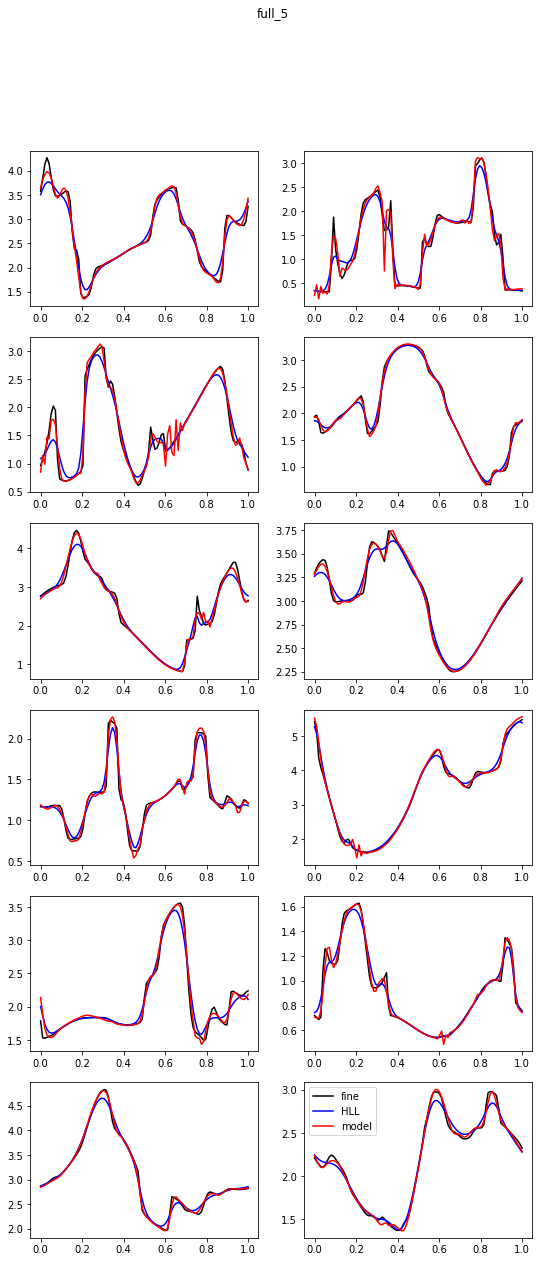

In [ ]:
for_one_channel(2,w_coarse,w_coarse_HLL, w_final_projected)

### Pair plot

In [ ]:
def pair_plot(errors_model,errors_HLL):    
    
    all_errors_model=np.reshape(errors_model,[-1,3])
    all_errors_HLL=np.reshape(errors_HLL,[-1,3])

    fig,ax0=plt.subplots(figsize=(9,9))
    fig.suptitle(family_trainer.name)
    ax0.scatter(all_errors_HLL[:,0],all_errors_model[:,0],s=1,color='r',alpha=0.5,label=r"$\rho$")
    ax0.scatter(all_errors_HLL[:,1],all_errors_model[:,1],s=1,color='g',alpha=0.5,label=r"$\rho V$")
    ax0.scatter(all_errors_HLL[:,2],all_errors_model[:,2],s=1,color='b',alpha=0.5,label=r"$E$")
    ax0.legend()
    xx=np.linspace(0,2,10)
    ax0.set_xlabel("errors_HLL")
    ax0.set_ylabel("errors_model")
    ax0.set_ylim(0,2)
    ax0.set_xlim(0,2)
    ax0.plot(xx,xx,"k")

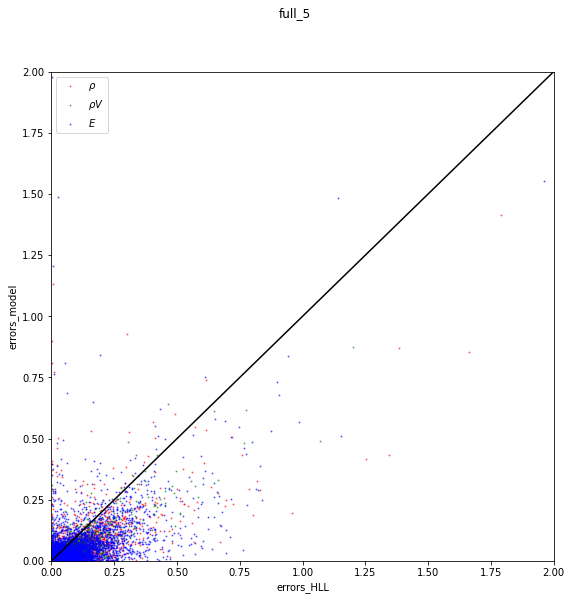

In [ ]:
pair_plot(errors_model,errors_HLL)

## Testons sur le jeu 'changing' (non périodique)

In [ ]:
#il serait préférable de mettre une BC adapté à un jeu non périodique. Mais BC reflexif marche très mal

#attention, modification des paramètres globaux
param.BC_solver=param.BC_model=Param.BC_periodic #on garde quand même périodic
genParam.kind=GenParam.kind_changing
W_val, Y_val = core.compute_fine_solutions_3(genParam,param, nb_t)
best_agent.load_WY_valid(W_val, Y_val)

durée du calcul de la solution fine: 1.7674047946929932

In [ ]:
w_coarse, w_final_projected,w_coarse_HLL,errors_model,errors_HLL=check_Nan_compute_errors()


nombre de Nan produit par le modèle: 0
nombre de Nan produit par HLL: 0
nombre de Nan dans la solution de référence: 0
nombre de big error produit par le modèle: 0
nombre de big error produit par HLL: 0
nombre de big error produit par la solution de référence: 0
error_model 0.015360002
error_HLL 0.028446464
score 1.8519831


### Densités

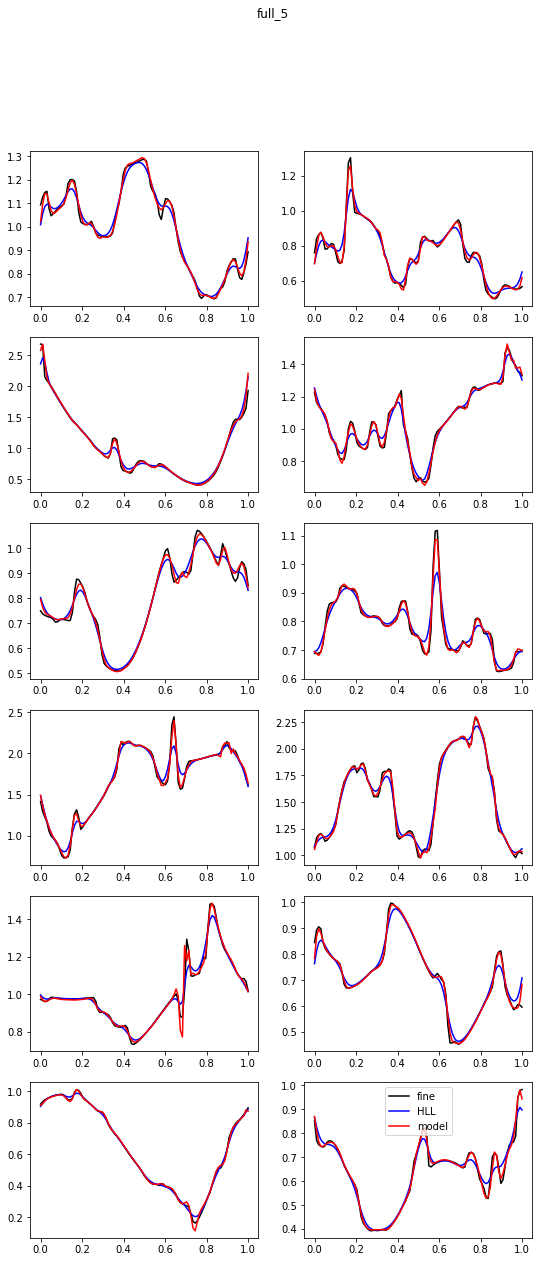

In [ ]:
for_one_channel(0,w_coarse,w_coarse_HLL, w_final_projected)

### rho V

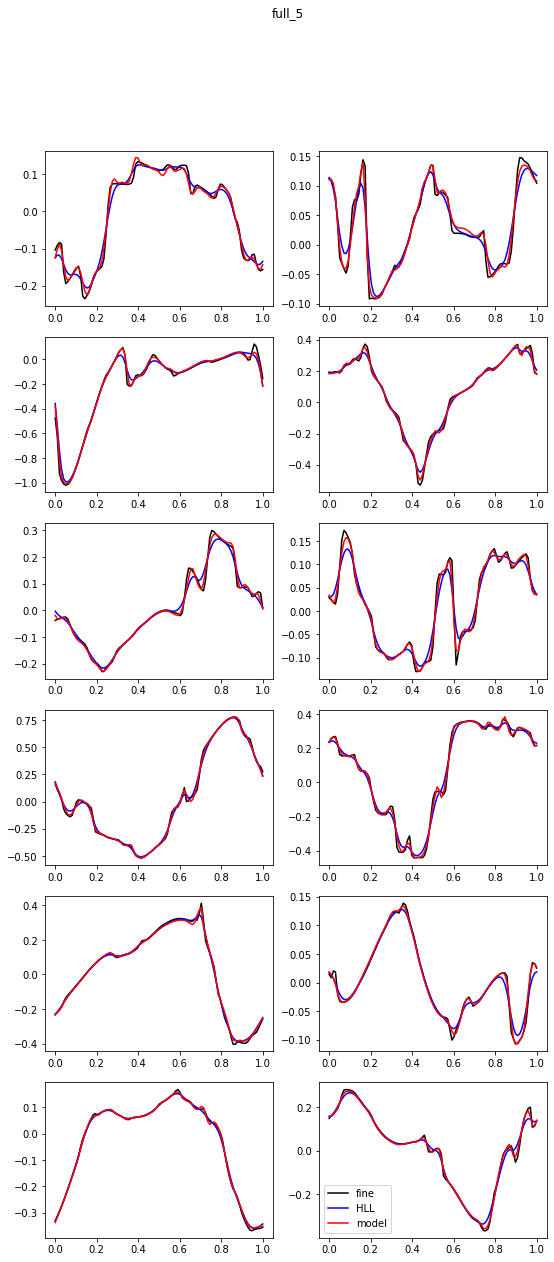

In [ ]:
for_one_channel(1,w_coarse,w_coarse_HLL, w_final_projected)

### Energie

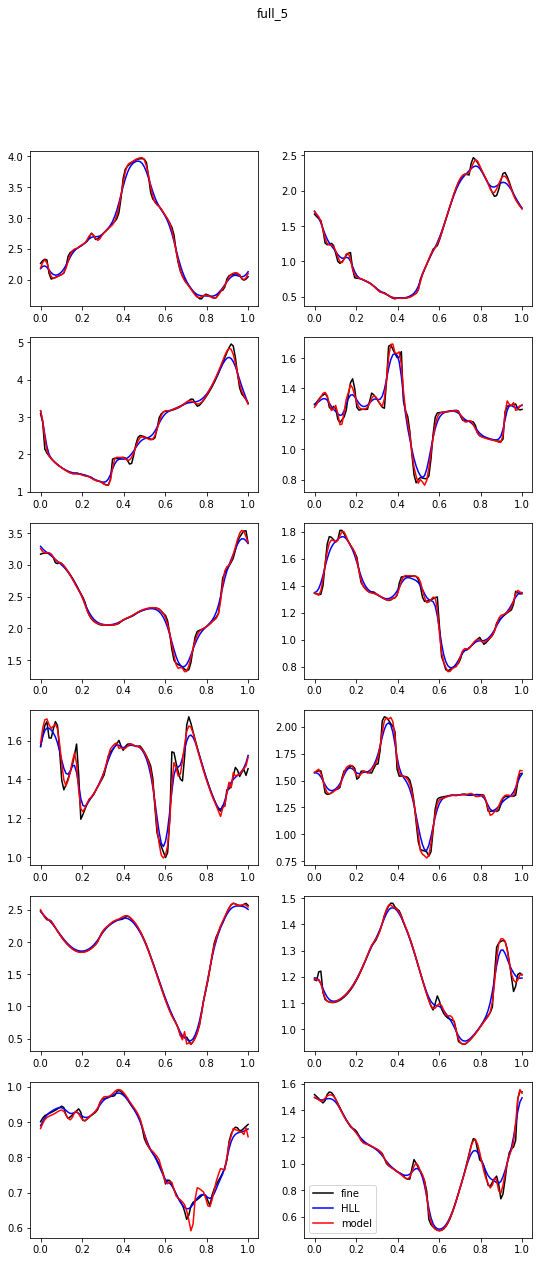

In [ ]:
for_one_channel(2,w_coarse,w_coarse_HLL, w_final_projected)

### Energie

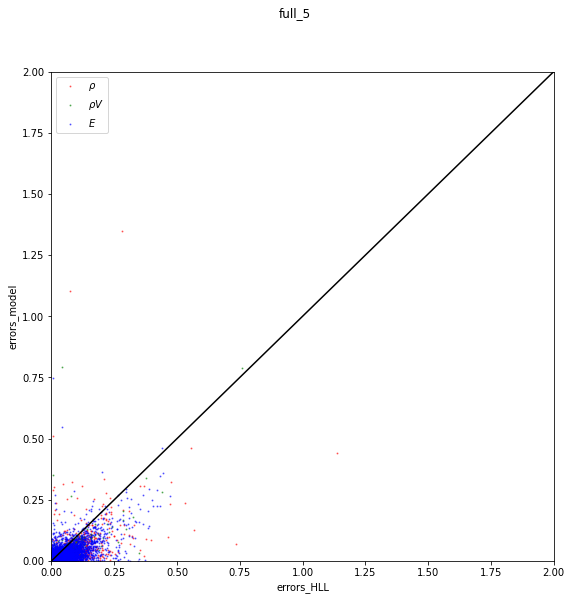

In [ ]:
pair_plot(errors_model,errors_HLL)

## Testons le long du temps

In [ ]:
def compare_along_the_time(kind):
    #on garde la BC_reflexive
    if kind==GenParam.kind_sod:
        param.BC_model=param.BC_solver=Param.BC_neumann
    genParam.kind=kind
    generator=FuncGenerator(genParam,param,k_tf32)
    
    model_addi=best_agent.model
    W_init = generator.init_W()

    nb_t = 500

    proj=Projecter(param.nx_ratio,32)
    print(W_init.shape)
    W_init_coarse=proj.projection(W_init)
    
    res_fine=core.compute_solutions(param, nb_t, W_init, False,k_tf32)
    res_fine_proj=[proj.projection(res) for res in res_fine]
    res_fine_proj=k_tf32.stack(res_fine_proj)

    res_coarse=core.compute_solutions(param, nb_t, W_init_coarse, True,k_tf32)

    res_coarse_model=[]
    w_coarse=W_init_coarse
    for t in range(nb_t):

        var = core.Var(w_coarse, param, k_tf32)
        Fnum_HLL = core.Flux_HLL(var, param, k_tf32)
        dFnum_HLL = (Fnum_HLL[:, 1:, :] - Fnum_HLL[:, :-1, :])

        X = var.get_augmentation()
        addi = model_addi(X)
        dFnum=dFnum_HLL+addi

        w_coarse = w_coarse - param.dt_over_dx_coarse * dFnum
        res_coarse_model.append(w_coarse)

    res_coarse_model=k_tf32.stack(res_coarse_model)

    step=100
    nb_res=nb_t // step

    if kind!="sod":
        fig, ax = plt.subplots(nb_res,5,figsize=(10*2,nb_res*3))
        for i in range(nb_res):
            t=i*step
            for j in range(5):
                ax[i,j].plot(res_fine_proj[t,j,:,0],color="k",label="HLL")
                ax[i,j].plot(res_coarse[t,j,:,0],color="b",label="HLL")
                ax[i,j].plot(res_coarse_model[t,j,:,0],color="r",label="HLL")
        ax[0,0].legend()
    else:
        fig, ax = plt.subplots(nb_res,1,figsize=(10,nb_res*3))
        for i in range(nb_res):
            t=i*step
            ax[i].plot(res_fine_proj[t,0,:,0],color="k",label="HLL")
            ax[i].plot(res_coarse[t,0,:,0],color="b",label="HLL")
            ax[i].plot(res_coarse_model[t,0,:,0],color="r",label="HLL")
        ax[0].legend()    

    fig.tight_layout()
    
    
    errors_HLL=tf.reduce_mean((res_fine_proj-res_coarse)**2,axis=[1,2,3])
    errors_model=tf.reduce_mean((res_fine_proj-res_coarse_model)**2,axis=[1,2,3])
    

    fig,ax=plt.subplots()
    ax.plot(errors_HLL,label="HLL")
    ax.plot(errors_model,label="model")

    if (np.max(errors_model)>0.1):
        ax.set_ylim(0,0.1)
    
    ax.legend()
    ax.set_xlabel("time")

    plt.show()



### kind Loop

(64, 1000, 3)


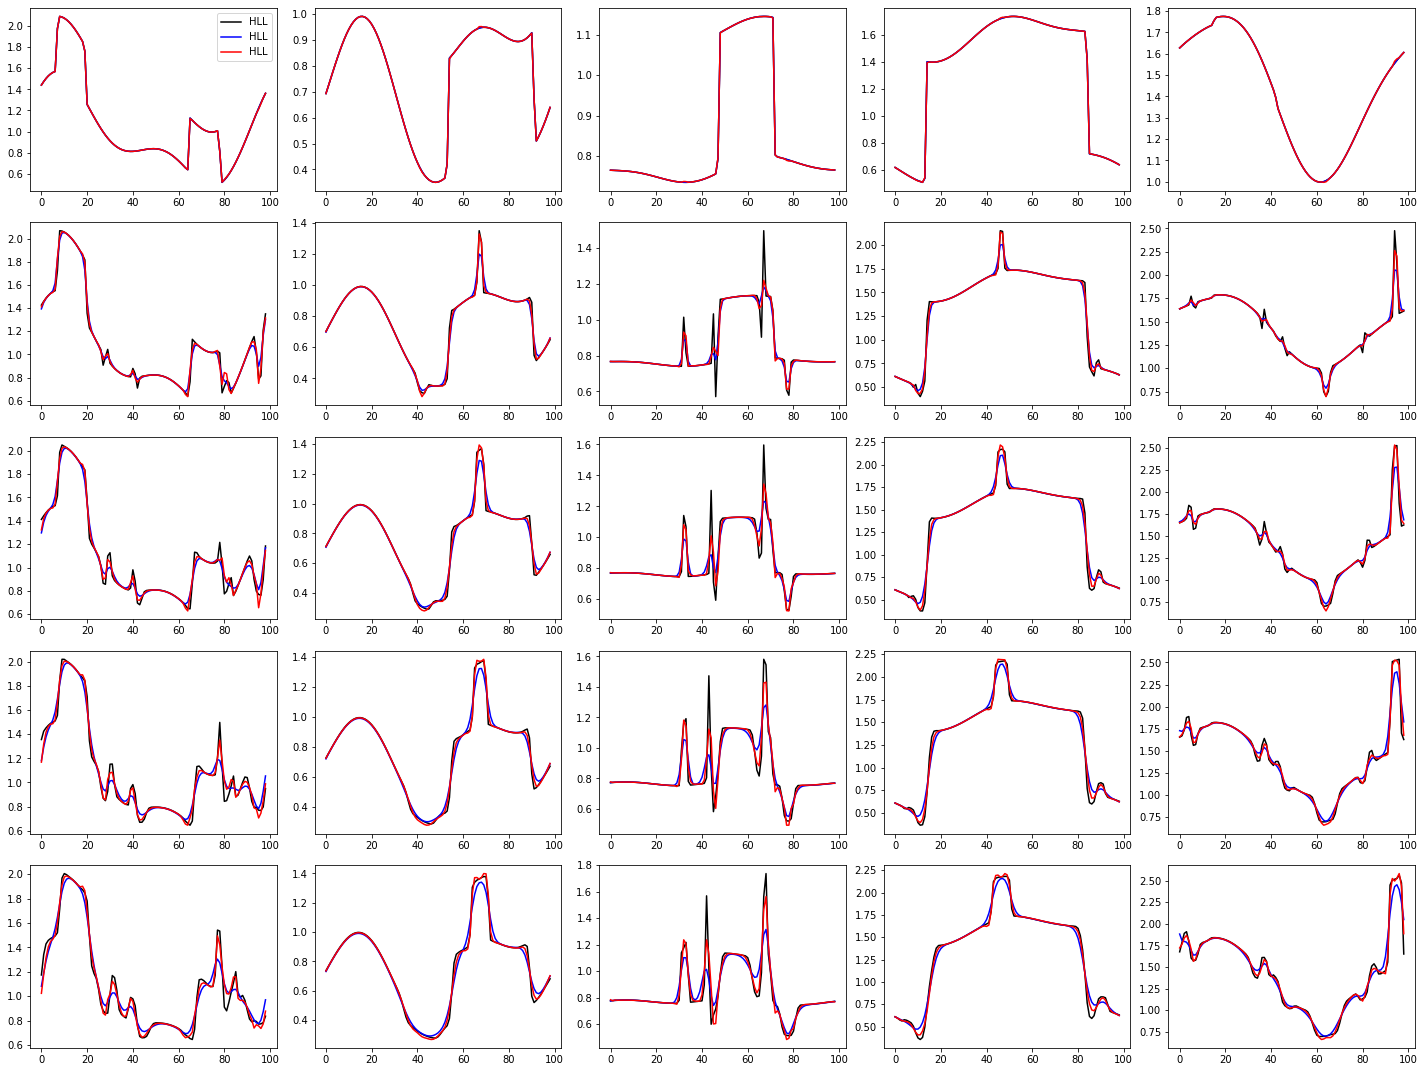

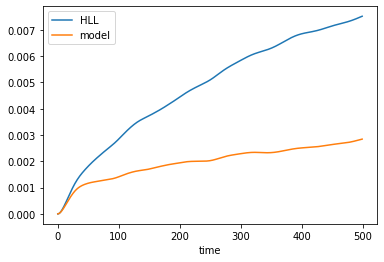

In [ ]:
compare_along_the_time(GenParam.kind_loop)

### kind changing

(64, 1000, 3)


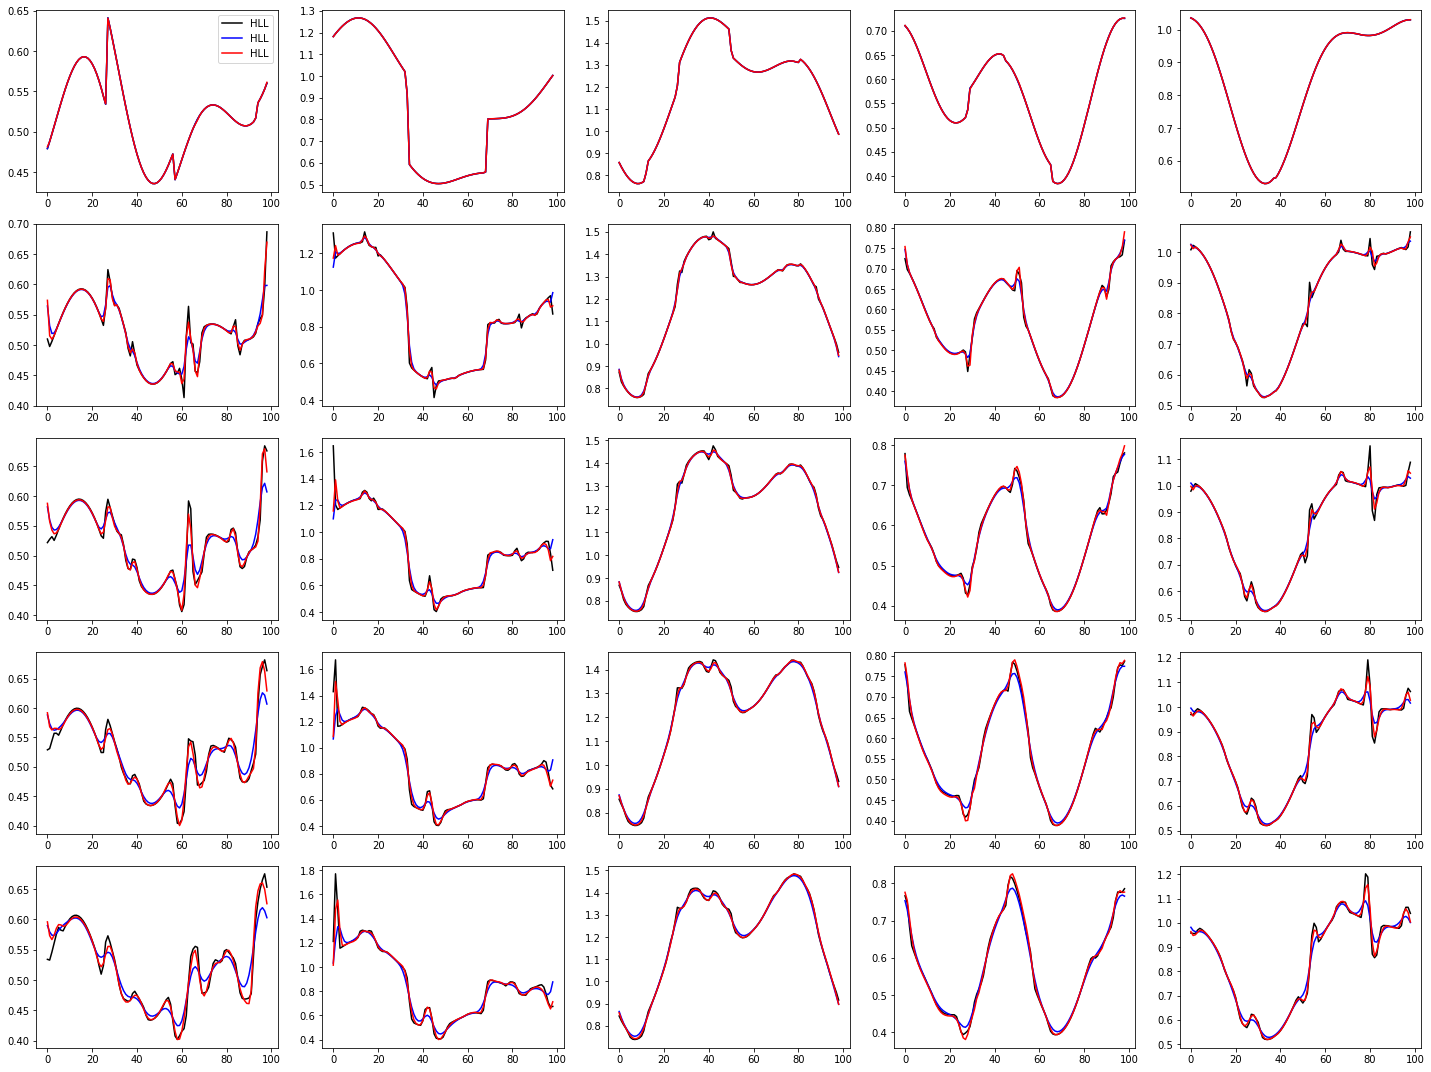

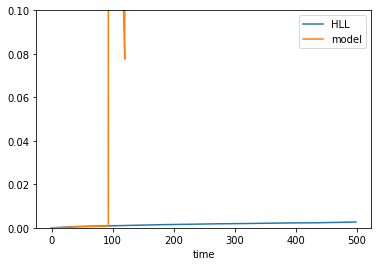

In [ ]:
compare_along_the_time(GenParam.kind_changing)

### kind Sod

(1, 1000, 3)


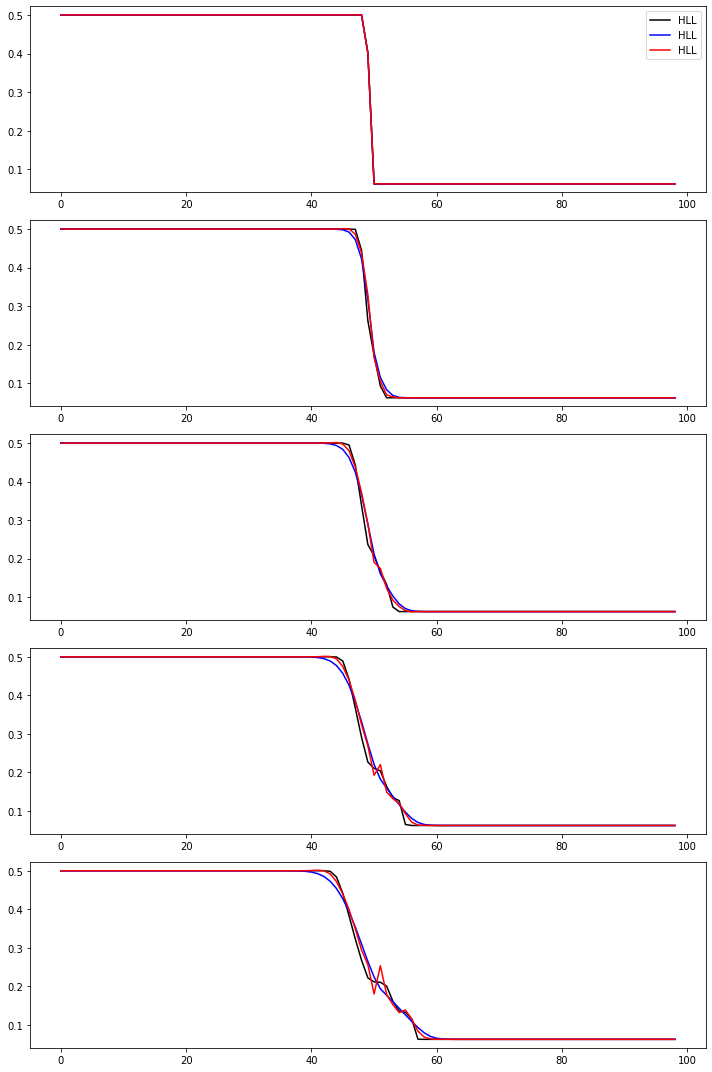

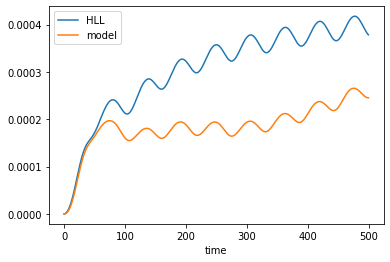

In [ ]:
compare_along_the_time(GenParam.kind_sod)